# Сначала подгружаем все необходимые библиотеки, функции и классы

In [4999]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score # Функция для разделения данных на части (train_test_split)
from sklearn.preprocessing import StandardScaler, RobustScaler # Классы для масштабирования данных
from sklearn.ensemble import RandomForestRegressor # Класс для создания модели Случайный Лес
from sklearn.metrics import r2_score as r2  # Функция для подсчета точности модели
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime 

import matplotlib # Импорт библиотеки визуализаций
import matplotlib.pyplot as plt # Импорт модуля печати графиков из библиотеки matplotlib
import seaborn as sns # Еще один модуль для печати графиков (на курсе не изучался)
%matplotlib inline 

# Исключаем предупреждения

In [5000]:
import warnings
warnings.filterwarnings('ignore')

#  Устанавливаем одинаковый шрифт

In [5001]:
matplotlib.rcParams.update({'font.size': 14})

# Функция для подсчета метрик и 2 графика - сравнение предсказаний с истинными значениями

In [5002]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3))) # Расчет метрики R2 на тренировочных данных
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3))) # Расчет метрики R2 на тестовых данных
    
    plt.figure(figsize=(18,10))  # Задаем размер графика
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values') # Предсказанные значения
    plt.ylabel('True values') # Истинные значения
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

# Описание датасета курсового проекта:

    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры

# Загрузим тренировочный датасет с сайта Kaggle

In [5003]:
train_df = pd.read_csv("train.csv") # загрузила из своего корневого каталога
train_df.tail() # Просмотрим файл train, его последние строки

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


# Посмотрим на типы данных файла train

In [5004]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

###### Видно, что в тренировочном датасете 10000 строк и 20 столбцов. 1) тип ID квартиры указан вещественным, но это лишь имя и по нему сравнивать квартиры друг с другом нельзя. 2) Отметим, что DistristId так же кажется вещественным, но на самом деле это не так, т.к. нельзя сказать что один район хуже другого зная только его номер. Поэтому будем работать с ним как с категориальным признаком

###### Вывод: Нужно создать функцию, меняющую типы данных, потому что это надо будет делать еще и для тестового датасета. Чтобы типы данных совпадали. К тому же видно, что некоторые целочисленные признаки (Rooms, HouseFloor) указаны как float64

# Загрузим тестовый датасет с сайта Kaggle

In [5005]:
test_df = pd.read_csv("test.csv")
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


###### Видно, что в тестовом датасете 5000 строк и 19 столбцов (отсутствует целевая переменная price, которую мы должны предсказать)

# Посмотрим на типы данных файла test

In [5006]:
test_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

###### Видим, что они совпадают с типами на train, и некоторые так же нуждаются в замене

# Приведем типы в нужный вид (создадим функцию, меняющую типы данных)

In [5007]:
def types_optimizing(df):
    df['Id'] = df['Id'].astype(str)
    df['DistrictId'] = df['DistrictId'].astype(str)
    df['Rooms'] = df['Rooms'].astype(int)
    df['HouseFloor'] = df['HouseFloor'].astype(int)
    
    return df

# Применим функцию оптимизации типов к нашим данным

In [5008]:
train_df = types_optimizing(train_df)
test_df = types_optimizing(test_df)

# Проверим как поменялись типы данных

In [5009]:
train_df.dtypes

Id                object
DistrictId        object
Rooms              int32
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor         int32
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [5010]:
test_df.dtypes

Id                object
DistrictId        object
Rooms              int32
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor         int32
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

# 1. Проведем EDA (exploratory data analysis) с целью:
- Найти выбросы
- Найти пропуски
- Найти идеи для новых фич (признаков)

EDA включает 3 шага (изучение целевой переменной, изучение признаков отдельно от целевой переменной, посмотреть как признаки влияют на целевое значение)

# Изучим целевую переменную

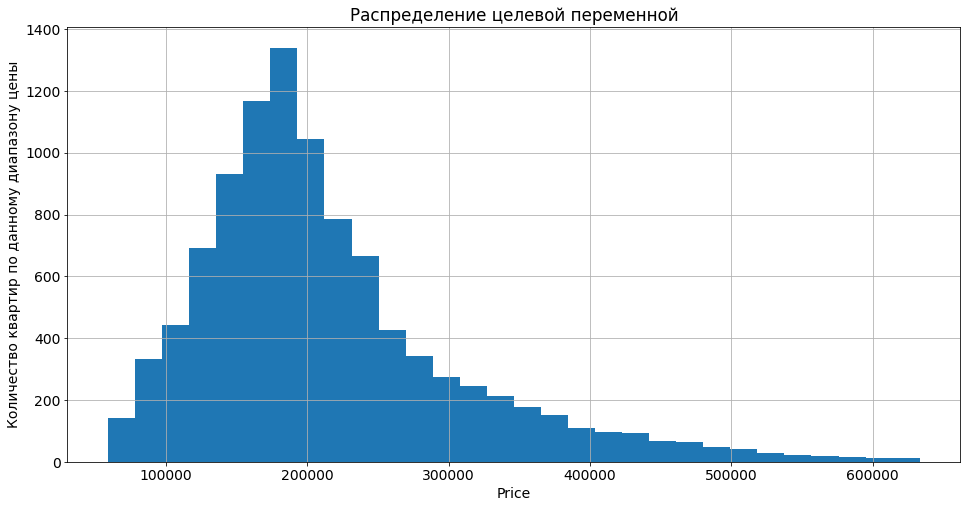

In [5011]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Количество квартир по данному диапазону цены')
plt.xlabel('Price')

plt.title('Распределение целевой переменной')
plt.show()

###### Видим, что распределение цены вполне правдоподобное, значит делать с ней ничего не будем.

# Изучим признаки

#### - Вещественные признаки 

In [5012]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Смотрим на основные статистики, ищем признаки, где есть странности: 1)min и max значения, что может говорить о наличии некорректных данных 2) большую разницу в mean и mediana, что может говорить о выбросах
   - Rooms: 1) есть 0 комнат и целых 19
   - Square: 1) кто-то живет на 1 м.кв, а кто-то на 641 м.кв)
   - LifeSquare: 1) кто-то живет на 0,3 кв.м, а кто-то на 7480 м.кв)
   - KitchenSquare: 1) есть кухня 0 кв.м[но такое может быть в студиях], а есть 2014 м.кв
   - HouseFloor: 1) есть 0-вая этажность дома
   - HouseYear: 1) видим аномальное среднее значение, и есть год постройки 8-значный,а должен быть 4-значный
   - Social_3 : 2) видим большую разницу в 4 раза между средним и медианой
   

#### - Номинативные признаки (помним о том, что категориальные признаки надо переводить в вещественные, чтобы они играли роль для моделей)

In [5013]:
train_df.select_dtypes(include='object').columns.tolist() # Посмотреть какие признаки номинативные

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

###### Посмотрим сколько разных районов есть в датасете и какое количество квартир в каждом из них:

In [5014]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

Видим, что районов слишком много(205шт) для того, чтобы переводить их в бинарные признаки, менять числа на числа тоже нет смысла, как и feature encoding - кодирование через другой признак. Применим 4й вариант - описать признак через себя же (т.е. через количество квартир в этом районе).

###### Посмотрим на остальные  номинативные признаки:

In [5015]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [5016]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [5017]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Видим, что у всех трех признаков есть по 2 категории А и В. В дальнейшем заменим их на вещественные 0 и 1.

# 2. Обработаем выбросы
Это или очень большие или очень маленькие значения и их мало.
Что будем делать:
 - Выкидывать (только на train, test и valid не трогаем никогда!)
 - Заменять разными способами (среднее, медиана, np.clip и т.д.)
 - Делать доп.фичу (= метку, показывающую, что в этом обьекте в этом признаке был выброс)
 - Ничего не делать

## Rooms
Посмотрим на значения, на EDA мы уже выяснили что есть неадекватные цифры. Создадим новую фичу под выбросы и обработаем их.

In [5018]:
train_df['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
19       1
6        1
Name: Rooms, dtype: int64

Видим что в 8 квартирах 0 комнат и есть слишком большие квартиры >= 6 комнат. Такого быть не может, ограничим число комнат между [1 и 6]

###### Создадим новую фичу под выбросы из комнат.

In [5019]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df['Rooms_outlier'].value_counts()

0    9988
1      12
Name: Rooms_outlier, dtype: int64

Видим, что было 12 таких выбросов

###### Вставим вместо 0 значение 1, а вместо аномальных значений - медианы

In [5020]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [5021]:
train_df['Rooms'].value_counts()

2    3884
1    3713
3    2235
4     150
5      18
Name: Rooms, dtype: int64

Теперь данные выглядят более правдоподобно.

# KitchenSquare

In [5022]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

Видим, что есть слишком большие кухни. Значение 0 или маленькие не будем считать выбросами, поскольку бывают квартиры-студии без кухонь. Чтобы понять какое максимальное адекватное значение посчитаем квантиль с правой стороны. И все что выше этого значения будем считать выбросом. 

###### Подберем вручную наиболее адекватный правый квантиль

In [5023]:
train_df['KitchenSquare'].quantile(.985)

14.0

Видим, что после квантиля 98,5% начинаются слишком большие кухни, оставим порог равный 14 м.кв.
Пропусков в KitchenSquare нет. Поэтому не будем это фиксировать в коде. Левую границу обрабатывать не будем, допустим, что есть кухни, совмещенные с комнатой и тогда их площадь может быть маленькой 0, 1, 2, 3...м.кв. 

###### Заполним значения превышающие 14 м.кв. медианой. Задаем именно число, а не квантиль, потому что по мере обхода цикла квантиль смещается влево, а я хочу, чтобы значение 14 осталось в датасете как адекватное и не отсекалось.

In [5024]:
condition = train_df['KitchenSquare'] > 14 
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()


In [5025]:
train_df['KitchenSquare'].value_counts()

1.0     2460
8.0     1306
6.0     1176
5.0     1169
10.0    1075
9.0      843
0.0      697
7.0      609
12.0     249
11.0     233
13.0      67
14.0      51
4.0       39
3.0       22
2.0        4
Name: KitchenSquare, dtype: int64

Теперь данные выглядят более правдоподобно.

###### Посмотрим есть ли кухни по площади больше, чем сама квартира.

In [5026]:
(train_df['KitchenSquare'] > train_df['Square']).value_counts()

False    10000
dtype: int64

Таких кухонь нет, все в порядке. А жилую площадь площадь кухни может превышать вполне.

# HouseFloor, Floor

In [5027]:
train_df['HouseFloor'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  36,  37,  38,  39,  40,  44,
        45,  47,  48,  99, 117])

Видим, что есть выбросы 0, 99 и 117 этажей. Будем от них избавляться.

In [5028]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

Видим, что в этажах квартир выбросов нет, значения вполне адекватны.

In [5029]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

Видим, что очень много квартир находятся на этажах, превышающих этажность дома. Будем это исправлять.

###### Создадим новую фичу под выбросы из этажности домов. Отправим в выбросы тот момент, когда этаж квартиры > этажа дома 

In [5030]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']) | (train_df['HouseFloor'] > 48), 'HouseFloor_outlier'] = 1

###### Заменим этажность равную 0 или большую, чем 48, а так же где Floor > HouseFloor на этаж, указанный для id квартиры. То есть поднимем этажность хотя бы до указанного этажа.

In [5031]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['Floor']

In [5032]:
train_df.loc[(train_df['HouseFloor'] > 48) | (train_df['Floor'] > train_df['HouseFloor']), 'HouseFloor'] = train_df['Floor']

In [5033]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

Видим, что благодаря изменениям в признаках Floor и HouseFloor больше нет выбросов.

# HouseYear

In [5034]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

Видим аномальные верхние значения, будем их обрабатывать, заменим все что выше текущего года на текущий год. И создадим фичу под выбросы.

In [5035]:
current_year = datetime.now().year
train_df['HouseYear_outlier'] = 0
train_df.loc[train_df['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
train_df.loc[train_df['HouseYear'] > current_year, 'HouseYear'] = current_year

In [5036]:
train_df['HouseYear'].sort_values(ascending=False)

8828    2021
9163    2021
7721    2020
9122    2020
7955    2020
        ... 
7610    1916
6250    1914
2066    1912
2795    1912
6794    1910
Name: HouseYear, Length: 10000, dtype: int64

# Square

In [5037]:
train_df['Square'].sort_values(ascending=False)

9229    641.065193
726     604.705972
7010    409.425181
1906    275.645284
7644    212.932361
           ...    
161       2.954309
8572      2.596351
9869      2.377248
4496      1.988943
7470      1.136859
Name: Square, Length: 10000, dtype: float64

###### Видим, что есть как слишком маленькие так и слишком большие площади квартир. Для оценки адекватности размеров посмотрим на квантили. А слишком маленькие площади квартир заменим на 20м.кв (исходя из знаний о минимально возможной площади квартиры и нормы в 18м.кв на человека)

In [5038]:
train_df['Square'].quantile(.9997)

275.68541804493896

###### Подобрали вручную правую границу наиболее адекватную  и теперь меняем выбросы.

In [5039]:
condition = train_df['Square'] > train_df['Square'].quantile(.9997)
        
train_df.loc[condition, 'Square'] = train_df['Square'].quantile(.9997)

In [5040]:
condition1 = train_df['Square'] < 20 
        
train_df.loc[condition1, 'Square'] = 20

###### Проверяем как получилось.

In [5041]:
train_df['Square'].sort_values(ascending=False)

7010    275.685418
9229    275.685418
726     275.685418
1906    275.645284
7644    212.932361
           ...    
4496     20.000000
7470     20.000000
9869     20.000000
4800     20.000000
1401     20.000000
Name: Square, Length: 10000, dtype: float64

# LifeSquare

In [5042]:
train_df['LifeSquare'].sort_values(ascending=False)

8000    7480.592129
9229     638.163193
5183     461.463614
7010     410.639749
357      263.542020
           ...     
9975            NaN
9978            NaN
9981            NaN
9983            NaN
9991            NaN
Name: LifeSquare, Length: 10000, dtype: float64

###### Видим, что есть выбросы в виде больших площадей, а так же ранее мы видели, что есть слишком маленькие минимальные жилые площади 0,3м.кв, что так же не адекватно. Пропуски обработаем позже. Мы знаем, что в Square и KitchenSquare не было пропусков, поэтому можно воспользоваться их разностью и еще вычесть 3м.кв на санузел/кладовую, чтобы получить адекватную жилую площадь.

Сначала исправим аномально большие значения.

In [5043]:
condition2 = train_df['LifeSquare'] > train_df['Square'].max()

In [5044]:
train_df.loc[condition2, 'LifeSquare'] = train_df['Square'].max() - train_df['KitchenSquare'] - 3

Теперь исправим аномально маленькие значения. Мы знаем, что минимальная квартира у нас 20м.кв. А минимальная жилая площадь (комната примерно 9м.кв). Исходя из этого делаем замены неадекватно маленьких жилых площадей.

In [5045]:
condition3 = train_df['LifeSquare'] < 9

In [5046]:
train_df.loc[condition3, 'LifeSquare'] = 9

In [5047]:
train_df.loc[train_df['LifeSquare'] < 9]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier


Проверили, теперь нет жилых площадей < 9м.кв.

Теперь проверим условие, что Lifesquare не должна быть больше Square.

In [5048]:
(train_df['LifeSquare'] > train_df['Square']).value_counts()

False    9528
True      472
dtype: int64

Мы видим, что в 472 обьектах жилая площадь превышает вообще площадь квартиры. Заменим в этих квартирах жилую площадь на разницу между Square - Kitchensquare - 3

In [5049]:
condition4 = train_df['LifeSquare'] > train_df['Square']

In [5050]:
train_df.loc[condition4, 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare'] - 3

In [5051]:
(train_df['LifeSquare'] > train_df['Square']).value_counts()

False    10000
dtype: int64

Теперь все общие площади находятся в разумных пределах.

Проверим еще раз, что у нас в результате преобразований не образовались слишком маленькие жилые площади.

In [5052]:
(train_df['LifeSquare'] < 9).value_counts()

False    10000
Name: LifeSquare, dtype: int64

# Social_3

Ранее мы отмечали, что в этом признаке среднее в 4 раза превосходит медиану. Значит справа есть выбросы.

In [5053]:
(train_df['Social_3']).value_counts()

0      2997
1      1861
3      1136
4       835
2       635
6       423
5       391
141     245
9       192
7       184
11      172
8       170
10      142
16      101
14       97
27       59
48       58
56       49
84       43
24       37
87       27
93       25
59       25
19       22
20       19
23       18
39       15
73       10
45        9
37        3
Name: Social_3, dtype: int64

###### Для наглядности построим гистограмму.

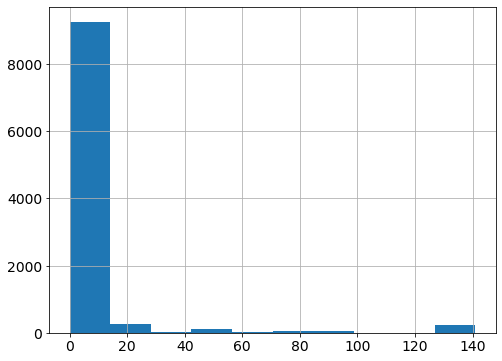

In [5054]:
train_df['Social_3'].hist(figsize=(8,6))
plt.show()

Видно, что основная масса значаний в пределах 50. И есть большой выброс > 125. Воспользуемся квантилем, чтобы убрать этот выброс.

In [5055]:
train_df['Social_3'].quantile(.975)

93.0

In [5056]:
round(train_df['Social_3'].mean())

8

###### Заменим выбросные значения на среднее. Округлим, т.к. Social_3 имеет тип int64.

In [5057]:
condition5 = train_df['Social_3'] > train_df['Social_3'].quantile(.975)
        
train_df.loc[condition5, 'Social_3'] = round(train_df['Social_3'].mean())

In [5058]:
(train_df['Social_3']).value_counts()

0     2997
1     1861
3     1136
4      835
2      635
6      423
8      415
5      391
9      192
7      184
11     172
10     142
16     101
14      97
27      59
48      58
56      49
84      43
24      37
87      27
93      25
59      25
19      22
20      19
23      18
39      15
73      10
45       9
37       3
Name: Social_3, dtype: int64

# Мы обработали все выбросы!

# ---------------------------------------------------------------------------------------------------------------

# 3. Обработаем пропуски.

In [5059]:
train_df.info() # Посмотрим в каких признаках есть пропуски

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  10000 non-null  object 
 1   DistrictId          10000 non-null  object 
 2   Rooms               10000 non-null  int32  
 3   Square              10000 non-null  float64
 4   LifeSquare          7887 non-null   float64
 5   KitchenSquare       10000 non-null  float64
 6   Floor               10000 non-null  int64  
 7   HouseFloor          10000 non-null  int64  
 8   HouseYear           10000 non-null  int64  
 9   Ecology_1           10000 non-null  float64
 10  Ecology_2           10000 non-null  object 
 11  Ecology_3           10000 non-null  object 
 12  Social_1            10000 non-null  int64  
 13  Social_2            10000 non-null  int64  
 14  Social_3            10000 non-null  int64  
 15  Healthcare_1        5202 non-null   float64
 16  Helth

###### Видим, что пропуски в двух признаках Lifesquare и Healthcare_1

# LifeSquare

Заменим пропуски на разницу между Square - Kitchensquare - 3 как это делали ранее. И на всякий случай пропишем условие, что в остальных признаках нет незаполненных значений. Так же создадим фичу под пропуски.

In [5060]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition6 = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition6, 'LifeSquare'] = train_df.loc[condition6, 'Square'] \
                                            - train_df.loc[condition6, 'KitchenSquare'] - 3

Проверим как получилось.

In [5061]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare               0
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
HouseYear_outlier        0
LifeSquare_nan           0
dtype: int64

Видим, что теперь нет пропущенных значений в Lifesquare

# Healthcare_1

###### Попробуем найти зависимости данного признака от других, чтобы примерно заполнить пропуски, которых очень много.

In [5062]:
x = train_df.loc[(train_df['Healthcare_1'].isna() == False), 'Healthcare_1'].values


In [5063]:
y = train_df.loc[(train_df['Healthcare_1'].isna() == False), 'Social_3'].values

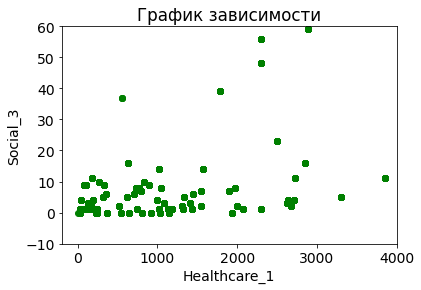

In [5064]:
plt.scatter(x, y, color='green')
plt.title('График зависимости')
plt.xlabel('Healthcare_1')
plt.ylabel('Social_3')
plt.axis([-200, 4000, -10, 60])
plt.show()

###### Путем перебора нашли график, где более-менее видна связь. Заполним пропуски по формуле x = 300y, где х - Healthcare_1, а у - Social_3

In [5065]:
train_df['Healthcare_1_nan'] = train_df['Healthcare_1'].isna() * 1

condition7 = (train_df['Healthcare_1'].isna()) \
             & (~train_df['Social_3'].isna()) 
        
train_df.loc[condition7, 'Healthcare_1'] = 300 * train_df.loc[condition7, 'Social_3']

###### Проверим, что пустых значений в признаке не осталось.

In [5066]:
train_df['Healthcare_1'].isna().sum()


0

In [5067]:
train_df.isna().sum()

Id                    0
DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Healthcare_1          0
Helthcare_2           0
Shops_1               0
Shops_2               0
Price                 0
Rooms_outlier         0
HouseFloor_outlier    0
HouseYear_outlier     0
LifeSquare_nan        0
Healthcare_1_nan      0
dtype: int64

# Мы обработали все пропуски!

# ---------------------------------------------------------------------------------------------------------------

# Теперь создадим функцию, которая будет обрабатывать выбросы и пропуски, т.к. это нужно делать в 3 датасетах (train, valid и test). Класс для пропусков и выбросов мы делать не будем, а будем отдельно считать медианы для каждого датасета, чтобы предотвратить переобучение (данная рекомендация есть в методическом пособии к курсу в разделе "Обучение с Учителем" на стр.15.
# Прогоним впоследствии все датасеты еще раз через эту функцию после разделения данных.

In [5068]:
def data_preprocessing(df):
    
# Rooms
    df['Rooms_outlier'] = 0
    df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 6), 'Rooms_outlier'] = 1
    df['Rooms_outlier'].value_counts()
    df.loc[df['Rooms'] == 0, 'Rooms'] = 1
    df.loc[df['Rooms'] >= 6, 'Rooms'] = df['Rooms'].median()
# KitchenSquare
    condition = df['KitchenSquare'] > 14      
    df.loc[condition, 'KitchenSquare'] = df['KitchenSquare'].median()
# HouseFloor, Floor
    df['HouseFloor_outlier'] = 0
    df.loc[df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
    df.loc[(df['Floor'] > df['HouseFloor']) | (df['HouseFloor'] > 48), 'HouseFloor_outlier'] = 1
    df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['Floor']
    df.loc[(df['HouseFloor'] > 48) | (df['Floor'] > df['HouseFloor']), 'HouseFloor'] = df['Floor']
# HouseYear
    current_year = datetime.now().year
    df['HouseYear_outlier'] = 0
    df.loc[df['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
    df.loc[df['HouseYear'] > current_year, 'HouseYear'] = current_year
# Square
    condition = df['Square'] > df['Square'].quantile(.9997)       
    df.loc[condition, 'Square'] = df['Square'].quantile(.9997)
    condition1 = df['Square'] < 20        
    df.loc[condition1, 'Square'] = 20
# Lifesquare
    condition2 = df['LifeSquare'] > df['Square'].max()
    df.loc[condition2, 'LifeSquare'] = df['Square'].max() - df['KitchenSquare'] - 3
    condition3 = df['LifeSquare'] < 9
    df.loc[condition3, 'LifeSquare'] = 9
    condition4 = df['LifeSquare'] > df['Square']
    df.loc[condition4, 'LifeSquare'] = df['Square'] - df['KitchenSquare'] - 3
# Social_3
    condition5 = df['Social_3'] > df['Social_3'].quantile(.975)    
    df.loc[condition5, 'Social_3'] = round(df['Social_3'].mean())
# Missings
# Lifesquare_1
    df['LifeSquare_nan'] = df['LifeSquare'].isna() * 1
    condition6 = (df['LifeSquare'].isna()) \
             & (~df['Square'].isna()) \
             & (~df['KitchenSquare'].isna())  
    df.loc[condition6, 'LifeSquare'] = df.loc[condition6, 'Square'] \
             - df.loc[condition6, 'KitchenSquare'] - 3
# Social_3
    df['Healthcare_1_nan'] = df['Healthcare_1'].isna() * 1
    condition7 = (df['Healthcare_1'].isna()) \
             & (~df['Social_3'].isna())       
    df.loc[condition7, 'Healthcare_1'] = 300 * df.loc[condition7, 'Social_3']
    
    return df

# 4. Построение новых признаков (в нашем случае замена категориальных на вещественные, т.к. модели плохо обучаются на категориях и создание новых признаков на основании старых).

Dummi- признаки

# Ecology_2, Ecology_3, Shops_2

In [5069]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

In [5070]:
train_df.dtypes

Id                     object
DistrictId             object
Rooms                   int32
Square                float64
LifeSquare            float64
KitchenSquare         float64
Floor                   int64
HouseFloor              int64
HouseYear               int64
Ecology_1             float64
Ecology_2               int64
Ecology_3               int64
Social_1                int64
Social_2                int64
Social_3                int64
Healthcare_1          float64
Helthcare_2             int64
Shops_1                 int64
Shops_2                 int64
Price                 float64
Rooms_outlier           int64
HouseFloor_outlier      int64
HouseYear_outlier       int64
LifeSquare_nan          int32
Healthcare_1_nan        int32
dtype: object

###### Видно,что тип данных изменился с object на int64

# DistrictID to DistrictSize

###### Создадим новую вещественную фичу на основании того, сколько квартир находится на территории каждого района.

In [5071]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [5072]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize
0,11809,27,3,115.027311,102.027311,10.0,4,10,2014,0.075424,...,0,0,1,305018.871089,0,0,0,1,1,851
1,3013,22,1,39.832524,23.169223,8.0,7,8,1966,0.118537,...,1,0,1,177734.553407,0,0,0,0,0,78
2,8215,1,3,78.342215,47.671972,10.0,2,17,1988,0.025609,...,3,1,1,282078.720850,0,0,0,0,0,652
3,2352,1,1,40.409907,36.409907,1.0,10,22,1977,0.007122,...,0,1,1,168106.007630,0,0,0,1,1,652
4,13866,94,2,64.285067,38.562517,9.0,16,16,1972,0.282798,...,0,6,1,343995.102962,0,0,0,0,1,89


## Исследвания на этом датасете показали, что бинарные фичи (такие как большой/маленький район, площадь квартиры... не увеличивают точность предсказания. Поэтому не будем их добавлять. А в некоторых случаях они даже приводили к ее снижению.

# MedPriceByDistrict ( В итоге убрала из фичей, т.к. она вызывала бОльшее переобучение и худшее значение кросс-валидации.

In [5073]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1,142799.434052
1,0,2,176210.812334
2,0,3,300610.359425
3,1,1,146735.671740
4,1,2,202666.310126


###### Видим, что с увеличением числа комнат цена растет. Значит можно добавить этот признак к датасету.

In [5074]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize,MedPriceByDistrict
0,11809,27,3,115.027311,102.027311,10.0,4,10,2014,0.075424,...,0,1,305018.871089,0,0,0,1,1,851,213530.788443
1,3013,22,1,39.832524,23.169223,8.0,7,8,1966,0.118537,...,0,1,177734.553407,0,0,0,0,0,78,146032.829834
2,8215,1,3,78.342215,47.671972,10.0,2,17,1988,0.025609,...,1,1,282078.720850,0,0,0,0,0,652,244005.272380
3,2352,1,1,40.409907,36.409907,1.0,10,22,1977,0.007122,...,1,1,168106.007630,0,0,0,1,1,652,146735.671740
4,13866,94,2,64.285067,38.562517,9.0,16,16,1972,0.282798,...,6,1,343995.102962,0,0,0,0,1,89,201584.441255


# Теперь создадим функции, которые будут создавать новые фичи, т.к. это нужно делать в 3 датасетах (train, valid и test). 


In [5075]:
def feature_generation(df):
    
# Ecology_2, Ecology_3, Shops_2
    binary_to_numbers = {'A': 0, 'B': 1}
    df['Ecology_2'] = df['Ecology_2'].replace(binary_to_numbers)
    df['Ecology_3'] = df['Ecology_3'].replace(binary_to_numbers)
    df['Shops_2'] = df['Shops_2'].replace(binary_to_numbers)
    
# DistrictID to DistrictSize
    district_size = df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
    df = df.merge(district_size, on='DistrictId', how='left') 

    
    return df


In [5076]:

def target_encoding_generation(df, y=None):
    if y is not None:
    
        df['Price'] = y.values
            
        med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'}) \
        .rename(columns={'Price':'MedPriceByDistrict'})
      
            
        med_price_by_district_median = med_price_by_district['MedPriceByDistrict'].median()
    
        df = df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            
        df['MedPriceByDistrict'].fillna(med_price_by_district_median, inplace=True)
        
        
    if y is None:
        X_train['Price'] = y_train.values
        
        med_price_by_district = X_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'}) \
        .rename(columns={'Price':'MedPriceByDistrict'})
      
        med_price_by_district_median = med_price_by_district['MedPriceByDistrict'].median()
        
        df = df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            
        df['MedPriceByDistrict'].fillna(med_price_by_district_median, inplace=True)
    
    return df


# 5. Отбор признаков

In [5077]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'HouseYear_outlier',
 'LifeSquare_nan',
 'Healthcare_1_nan',
 'DistrictSize',
 'MedPriceByDistrict']

In [5078]:
feature_names = ['Rooms', 'Square', 
                 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 
                     #'MedPriceByDistrict'
                     'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize']

target_name = 'Price'

Убрали невещественные признаки.

# 6. Разбиение на train, valid. Предобработка 3 датафреймов.

In [5079]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [5080]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [5081]:
X_train = data_preprocessing(X_train)
X_valid = data_preprocessing(X_valid)
test_df = data_preprocessing(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 24), (3300, 24), (5000, 24))

In [5082]:
X_train = feature_generation(X_train)
X_valid = feature_generation(X_valid)
test_df = feature_generation(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 25), (3300, 25), (5000, 25))

In [5083]:
X_train = target_encoding_generation(X_train, y_train)
X_valid = target_encoding_generation(X_valid)
test_df = target_encoding_generation(test_df)
X_train.drop('Price', axis = 1, inplace = True)

X_train.shape, X_valid.shape, test_df.shape

((6700, 26), (3300, 26), (5000, 26))

In [5084]:
X_train.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Rooms_outlier',
       'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan',
       'Healthcare_1_nan', 'DistrictSize', 'MedPriceByDistrict'],
      dtype='object')

###### Датафреймы заполнены данными. Оставим нужные признаки.

In [5085]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

###### Проверим нет ли пропусков в датасетах.

In [5086]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

# 7. Построение модели

###### Сначала обучим тренировочную модель

In [5087]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse', n_estimators = 200, max_depth = 9, max_features = 5)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=9, max_features=5, n_estimators=200,
                      random_state=21)

###### Предскажем цены на валидационном датасете и оценим качество.

Train R2:	0.817
Test R2:	0.683


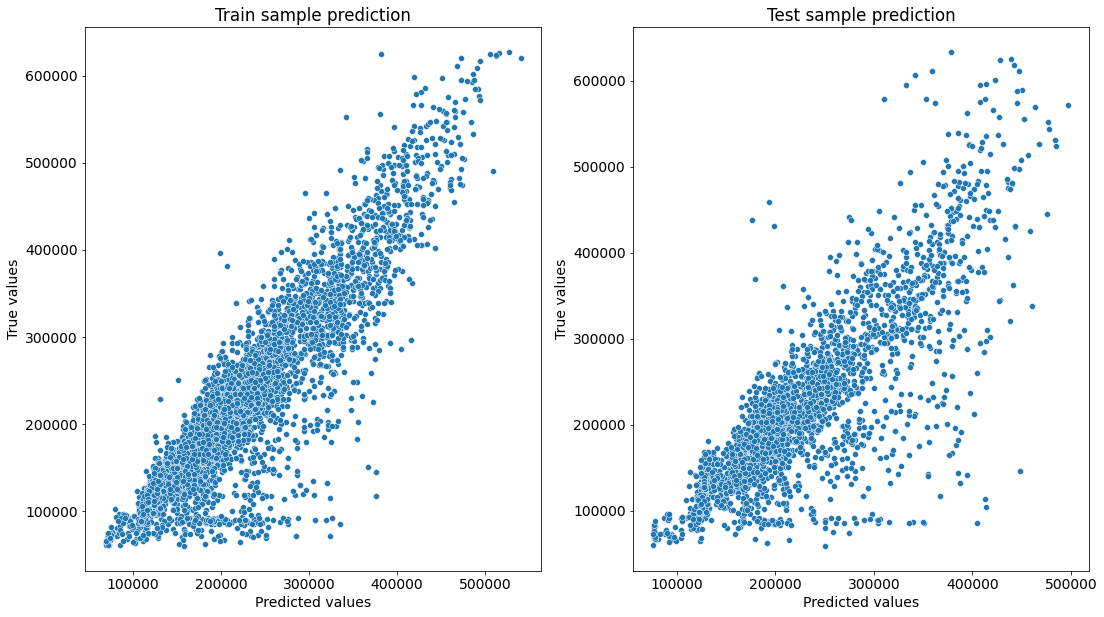

In [5088]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Кросс-валидация

In [5089]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.72187132, 0.67124203, 0.71431508])

In [5090]:
cv_score.mean()

0.7024761457557682

### По нескольким признакам видно, что переобучения нет, т.к.: 1) Небольшой размах между Train R2 и Test R2 2) График валидационных предсказаний очень похож на тренировочний 3) и на кросс-валидации мы получили практически то же число по точности.

#### Важность признаков

In [5091]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,2.675302e-01
0,Rooms,1.520978e-01
21,DistrictSize,1.108645e-01
2,LifeSquare,9.447361e-02
11,Social_2,5.994982e-02
10,Social_1,5.711134e-02
12,Social_3,5.176866e-02
3,KitchenSquare,3.668144e-02
6,HouseYear,3.106562e-02
7,Ecology_1,2.578423e-02


#### Мы видим, что нет слишком важного признака (превышающего 50%), но есть малозначимый HouseYear_outlier, однако если его убрать, то точность падает на 0,01%. Не будем этого делать, т.к. признаков итак не слишком много.

# Произведем подбор оптимальных параметров для модели методом GridSearchCV

In [4994]:
from sklearn.model_selection import GridSearchCV

In [4995]:
parameters = {'n_estimators': [150, 200, 250],
             'max_features': np.arange(5, 9),
             'max_depth': np.arange(5, 10)}

In [4996]:
clf = GridSearchCV(estimator=RandomForestRegressor(),
                  param_grid=parameters,
                  scoring='accuracy',
                  cv=5)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
cv_results = pd.DataFrame(clf.cv_results_)

In [ ]:
cv_results

### Модель выдала 60 различных комбинаций (расчет длится слишком долго, поэтому приведу результат), из них методом подбора я выбрала комбинацию, при которой выше точность и меньше переобучение
- n_estimators:    200
- max_depth':    9
- max_features:    5

# 8. Прогнозирование на тестовом датасете

In [5092]:
test_df.shape

(5000, 22)

In [5093]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [5094]:
predictions = rf_model.predict(test_df)
predictions

array([160343.87783342, 129117.82405816, 157988.79356696, ...,
       154612.29176752, 188917.24821492, 274038.37946708])

In [5095]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,160343.877833
1,5925,129117.824058
2,960,157988.793567
3,3848,140579.185458
4,746,222514.045691


In [5096]:
submit.to_csv('rf_submit_Perova.csv', index=False)